In [1]:
%load_ext notexbook

In [2]:
%texify --linespread 1.5 --code-font Monaco

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/pytorch-beautiful-ml-data/pydata-global?filepath=4_data_partitioning/data_partitioning.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leriomaggio/pytorch-beautiful-ml-data/blob/pydata-global/4_data_partitioning/data_partitioning.ipynb)
</span>

<span class="fn"><i>[Note]: </i> This notebook has been designed using the [$\text{no}\TeX\text{book}$](https://github.com/leriomaggio/notexbook-jupyter-theme) Jupyter notebook theme. 
Please **trust** the notebook to enable the theme.</span>

# Dataset Partitioning

## Data Partitioning in Machine Learning

To evaluate how well **Supervised** models _generalize_, data are usually _partitioned_ into a _training_ and a _test_ set.

![train_test_split](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/train_test_split.svg)

The *former* is used as the **reference**, and the **only** dataset on which the whole _training process_ of `ML`/`DL` models builds on; whereas the _latter_ is also referred to as the **held-out** dataset, emphasising that this data should be always kept **separate** from the _training data_, 
and only used _afterwards_ to test model *generalisation* capabilities.

On a very similar note, <ins>*training data*</ins> is usually further partitioned into a _validation_ set. This data is used to monitor and validate model's progress during the training, as if it was a 
*development beta version* of a more general test set. In fact, this data is sometimes also referred to as *development set* or <ins>_internal_</ins>[$^{\star}$](#fnstarval) *validation data*.

Therefore, **all** the rules applying to the *test* data, also apply to the *validation* data!

![train_test_split](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/train_validation_test2.svg)

<span id="fnstarval"><i>$^{\star}$: </i> As opposed to **external** validation data used for *test* partition.</span>
<span class="fn"><i>Source: </i> [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) _from_ **scikit-learn** documentation.</span>

⚠️ **Note**

It is worth mentioning that the same principles about data partitions, and their respective roles also applies to any `preprocessing`, and/or derived statistics is derived on the data *before* any actual training is performed. 

For example: **Standardising** a datasets is a common requirement for many machine learning models that might behave badly if the individual features do not more or less look like standard normally distributed data. 

To do so, `sklearn` provides the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) _transformer_ in the [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) package, which standardise each feature by removing the mean ($\mu$), and scaling to unit variance ($\sigma$).

The standard score of a sample $x$ is calculated as:
$$
z = \frac{(x-\mu)}{\sigma}
$$
where $\mu$ and $\sigma$ are respectively the *mean*, and the *standard deviation* of each feature among all the **training** samples!

Therefore:

**1**: <span class="texbook-turquoise">CORRECT</span> ✅

```python 
X_train, X_test = split(X)
scaler = StandardScaler()
scaler.fit(X_train)  # fit on training data ONLY!
...
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
```

**2**: <span class="texbook-red">**IN**CORRECT</span> ❌

```python 
scaler = StandardScaler()
scaler.fit(X)  # fit on the whole dataset
...
X_train, X_test = split(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
```

In particular, this is <span class="texbook-red">**incorrect**</span> because information from the _training_ set[$^{1}$](#fn1) would leak into the _test_ set, harming the whole principle of using this data to test how well a ML model is able to **generalise** on _unseen_ data. In other words, the _test_ data would not be truly _unseen_ to some extent.
Further examples of `preprocessing` methods as included in `sklearn` can be found in the official [documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).


<span id="fn1"><i>[1]: </i>Aggregated in the calculation of the $\mu$ and $\sigma$ parameters used for standardisation</span>

Therefore, as a **general rule of thumb**: _always apply data partitioning before anything else_.

To do so, `sklearn` provides an easy to use `train_test_split(*arrays, **options)` helper function, which wraps `(1)` input validation; and `(2)` the use of a more articulate and generic `ShuffleSplit.split` generator, i.e. `next(ShuffleSplit().split(X, y))` 

In this notebook, we will see how we can combine this, and more complex methods for data partitioning with `torch.utils.data.Dataset` objects, and its corresponding `DataLoaders`.

## Split a PyTorch `Dataset`

In order to work our ways into the maze of combining `torch.utils.data.Dataset` with `sklearn.model_selection` methods, let's start by loading our dataset of choice for this tutorial.

Once again, we will be using the `FER` `Dataset`, as provided in the `fer` module

Let's start by loading the dataset from `fer.py`

**Note**: if opening this notebook from Colab, please refer to this file: $\Rightarrow$ [`fer.py`](https://github.com/leriomaggio/pytorch-beautiful-ml-data/blob/main/4_data_partitioning/fer.py)

In [3]:
from fer import FER
from torch.utils.data import DataLoader

In [4]:
# load data partitions

fer_training = FER(root=".", download=True, split="train")
fer_validation = FER(root=".", download=True, split="validation")
fer_test = FER(root=".", download=True, split="test")

In [5]:
len(fer_training), len(fer_validation), len(fer_test)

(28709, 3589, 3589)

### Combining multiple PyTorch `Dataset`

Our discussion about data partitioning, will incidentally start from the opposite end: _how to combine multiple PyTorch Dataset into one_.

As already mentioned, `FER` pre-defined data partitions have been prepared to support a Kaggle/ICML challange. Therefore it is very likely that some sort of (_selection_) _bias_ in preparing samples distributions _may_ have been (intentionally?) applied, to make the life of contenders more difficult.

Well, combining multiple `torch` dataset is indeed very easy! Unsurprisingly, it is the **Python Data Model** that comes to the rescue once again!

The `torch.utils.data` package includes a [`ConcatDataset`](https://github.com/pytorch/pytorch/blob/32b4b51254dce410484cfc68052729227505ee24/torch/utils/data/dataset.py#L177) class which is specifically designed to _chain_ multiple dataset. Moreover, the `torch.utils.data.Dataset` class [implements](https://github.com/pytorch/pytorch/blob/master/torch/utils/data/dataset.py#L35) the `__add__` [method](https://docs.python.org/3/reference/datamodel.html#object.__add__) which clearly defines the expected behaviour when **two** `Dataset` instances are summed together:

In [6]:
type(fer_training + fer_validation)

torch.utils.data.dataset.ConcatDataset

**Therefore**, let's start by joining together the three pre-defined `FER` partitions

In [7]:
fer_dataset = fer_training + fer_validation + fer_test

In [8]:
len(fer_dataset), len(fer_dataset) == sum(map(len, (fer_training, fer_validation, fer_test)))

(35887, True)

### Set Determinism

Before proceeding any further, let's just allow for some _determinism_ and _future reproducibility_!

We will set the random seeds in both `Numpy` and `PyTorch` to ensure that generated data partitions will be exactly the same, everytime this notebook will be executed! 

On a more general note, **randomness** in a Machine Learning workflow appears in many steps:

1. *Data Preparation* (e.g. `pandas.sample` in our example?)
2. *Data Preprocessing* (e.g. `RandomApply` for our transformers?)
3. *Data Partitioning and Cross Validation* (**this notebook**)
4. *Model Weights Initialisation*
5. ...

All these factors can contribute to variations across runs, harming the reproducibility and/or replicability of the whole pipeline. Moreover, this is why it is always a good idea to be able to control the multiple source of randomness, _without_ necessarily relying on the *global* seed.

The **random seed** is a starting point for the sequence, and the guarantee is that if you start from the same seed you will get the same sequence of numbers. And so, you **also want to test your models with multiple seed values**!


In [9]:
import torch
import numpy as np

SEED = 189212  # 0b101110001100011100

np.random.seed(SEED)

torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

**Further reading**: [PyTorch Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html)

### Train-Test Split

Let's finally workout our first solution to partition a `torch.Dataset`!


First mention goes to the `built-in` method in `torch.utils.data` to [`random_split`](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#random_split) a `Dataset` into a list of `Subset` instances.

A `torch.utils.data.Subset` is a very simple class which combines together a `Dataset` and a `Sequence[int]` of indices to access its elements.

The `random_split` function expects a `dataset`, a list of `lengths`, and a `torch.Generator` instance (if any) to control the random permutations of indices, when creating the `Subset`.

So, to easily re-create the three `FER` partitions using the `random_split` function:

In [10]:
from torch.utils.data import random_split

In [11]:
fer_train, fer_valid, fer_test = random_split(fer_dataset, lengths=(28709, 3589, 3589), 
                                              generator=torch.Generator().manual_seed(920))

In [12]:
type(fer_train), type(fer_valid), type(fer_test)

(torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset)

In [13]:
list(map(len, (fer_train, fer_valid, fer_test)))  # lengths

[28709, 3589, 3589]

This worked as expected, however: 
1. specifying the actual number of samples per dataset is not very practical;
2. we could not apply any `stratification` to guide the selection.

In fact, let's have a look at class distributions with these three new partitions:

**Helper Functions**

We define two helper functions here that will be re-used also later to plot samples distributions among the given data partitions

In [14]:
28709+3589+3589

35887

In [15]:
35887-3589

32298

In [16]:
358900/32298

11.112143166759552

In [17]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
color_map = cm.tab10

def plot_class_counts(cls_count, title="", class_names=fer_training.classes):
    """Helper function to plot samples distributions per classes"""
    plt.title(title)
    colours = [color_map(i) for i in range(7)]
    plt.bar(range(7), cls_count, color=colours)
    plt.xticks(range(7), labels=class_names, rotation=90)
    plt.ylim(0, cls_count.max() + 1000)
    for i, c in enumerate(cls_count):
        plt.annotate(text=f"{c:,}", xy=(i-.25, c+200))
    plt.show()
    

def plot_samples_distribution(*partitions, 
                              chart_title,
                              partition_names=("train", "validation", "test")):
    for partition, name in zip(partitions, partition_names):
        labels_ = [emotion for _, emotion in iter(partition)]
        class_count = np.bincount(labels_)
        plot_class_counts(class_count, title=f"({chart_title}) {name.title()}")
    

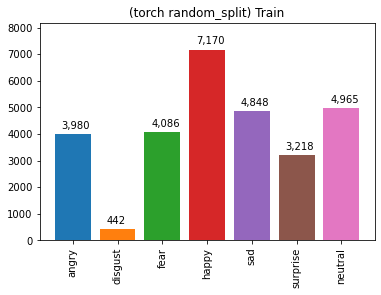

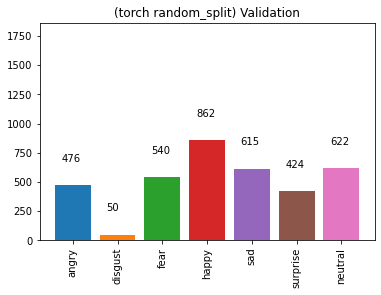

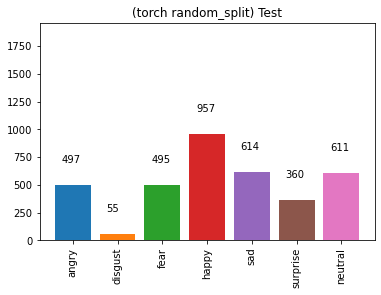

In [18]:
plot_samples_distribution(fer_train, fer_valid, fer_test, chart_title="torch random_split")

Similarly, we could implement our own version of `random_split` which is slightly different and leverages on [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split).

The only thing to keep in mind, is that `train_test_split` generates two partitions at a time, therefore, we should `train-test` split first, and `train-validation` split, afterword.

In [19]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split


def train_test_dataset_split(dataset, test_size=.25, validation_size=.25,
                             random_state=None, shuffle=True, with_stratification=False):
    
    if with_stratification:
        stratify = np.asarray([emotion for _, emotion in iter(dataset)])
    else:
        stratify = None
        
    train_indices, test_indices = train_test_split(np.arange(len(dataset)), 
                                                   test_size=test_size, shuffle=shuffle,
                                                   random_state=random_state,
                                                   stratify=stratify)
    test_subset = Subset(dataset, test_indices)
    train_subset = Subset(dataset, train_indices)
    if with_stratification:
        # update labels
        stratify = np.asarray([emotion for _, emotion in iter(train_subset)])
    
    train_indices, valid_indices = train_test_split(train_indices, test_size=validation_size, 
                                                    shuffle=shuffle, random_state=random_state,
                                                    stratify=stratify)
    train_subset = Subset(dataset, train_indices)
    valid_subset = Subset(dataset, valid_indices)
    return [train_subset, valid_subset, test_subset]
    

In [20]:
fer_train, fer_valid, fer_test = train_test_dataset_split(fer_dataset, test_size=.10, 
                                                          validation_size=.11,
                                                          with_stratification=True)

In [21]:
type(fer_train), type(fer_valid), type(fer_test)

(torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset)

In [22]:
list(map(len, (fer_train, fer_valid, fer_test)))  # lengths

[28745, 3553, 3589]

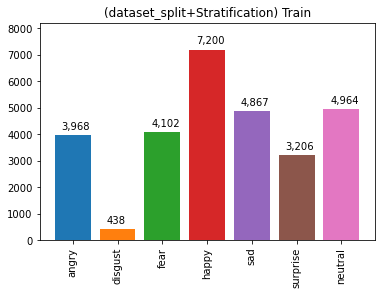

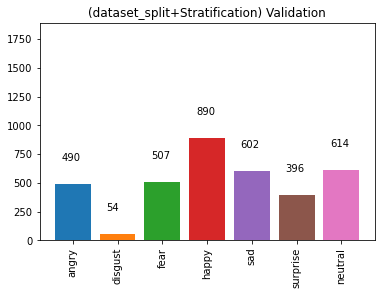

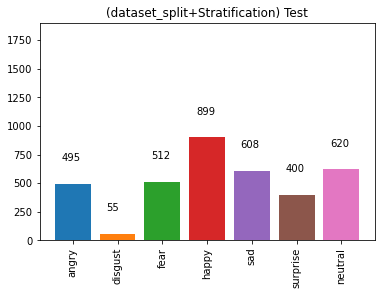

In [23]:
plot_samples_distribution(fer_train, fer_valid, fer_test, 
                          chart_title="dataset_split+Stratification")

As you can see, *stratification* has an impact in determining how samples are distributed among partitions. 

With **this** current implementation though, applying stratification is not that _flexible_ as it is in `sklearn` implementation, and as it should be.
In fact, we can specify whether or not applying stratification on the labels, but other stratification strategies can be used. 

For example, we might want to stratify using a _positive_ vs _negative_ vs _neutral_ emotion, for example. 

**Exercise**

As an exercise, please modify previous implementation to support this flexibility

In [24]:
#your code here

---

### Cross Validation

By partitioning the available data into three sets (i.e. _train_, _validation_, _test_), we 
drastically reduce the number of samples which are using for learning the model, 
and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this issue is a procedure called **Cross Validation** (`CV` in short).

(from [Wikipedia](https://en.wikipedia.org/wiki/Cross-validation_(statistics)))

> Cross-validation, sometimes called **rotation estimation**, or *out-of-sample testing*, 
> is (*a*) model validation technique for assessing how the results 
> of a statistical analysis will generalize to an independent data set.
> [$\ldots$]
> The **goal** of cross-validation is to test the model's ability 
> to predict new data that was not used in estimating it, in order to **flag problems** like 
> <ins>overfitting or selection bias</ins>.



#### How does `CV` works?

A **test set** is still **held out** for <ins>final evaluation</ins>, but the *validation set* is no longer intended as a single partition, in the `CV` strategy. 

In the most general settings, (i.e. `k-fold CV`), the _training set_ is split into **k smaller sets**, so that:

1. Select $k-1$ folds for training, $1$ fold for validation;
2. A model is **trained** using the selected $k - 1$ folds of the data;
3. the model is **validated** on the remaining $k_{th}$ fold kept out.
4. Repeat this process again (**<ins>re-initialising all model parameters</ins>**) by applying a different selection to the folds for training/validation **until** all the folds has been used once for validation.

5. Aggregate results for each data partitioning, and derive statistics (with confidence intervals) on model predictions and generalisation capabilities.

##### K-Fold Cross Validation Partitions

![cross_validation](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/cross_validation.svg)

<span class="fn"><i>Source: </i> [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) _from_ **scikit-learn** documentation.</span>

There exist multiple strategies (or variations) on how folds can be generated during a `CV`, and the [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) package provides classes and functions to handle different partitioning strategies, and data configurations. 

Among the many brilliant examples provided in `sklearn` documentation, I would strongly recommend 
[Visualizing cross-validation behaviour in scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html), which practically shows the effect of different data selection strategies when creating folds.

#### KFold and torch.Dataset

Now, let's see how we can **re-use** the `sklearn.model_selection.KFold` class with a `torch.Dataset`.

All the **Splitter** classes in `sklearn.model_selection` share the *same* API (as it is customary in `sklearn`, _ed._):

```python 
>>> from sklearn.model_selection import KFold
>>> KFold(n_splits: int,           # how many partitions to generate
          shuffle: bool = False    # whether applying data shuffling beforehand
          random_state: int or RNG # Crucial! Parameter to control randomness
         )
>>> kfold = KFold(n_splits=5, random_state=SEED)
>>> for train_indices, valid_indices in kfold.split(X)
...     X_train, X_val = X[train_indices], X[val_indices]
...
```

Now, `X` is supposed to be an _array-like_ object, usually a `numpy.ndarray`.

However, a `torch.Dataset` is indeed a **subscriptable** objects, so we can use is as an input parameter!

In [25]:
from sklearn.model_selection import KFold

In [26]:
kfold = KFold(n_splits=2, random_state=12345, shuffle=True)
for train_idx, test_idx in kfold.split(fer_dataset):
    print(train_idx, test_idx)

[    0     3     4 ... 35879 35880 35886] [    1     2     5 ... 35883 35884 35885]
[    1     2     5 ... 35883 35884 35885] [    0     3     4 ... 35879 35880 35886]


Unfortunately, what we **cannot** immediately do with a `torch.Dataset` is slicing a dataset based on a given a `torch.Tensor` (or `ndarray`) of indices:
```python
>>> fer_dataset[train_idx] ❌
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-29-ab9cc45f627e> in <module>
----> 1 fer_dataset[train_idx]

torch/utils/data/dataset.py in __getitem__(self, idx)
    207 
    208     def __getitem__(self, idx):
--> 209         if idx < 0:
    210             if -idx > len(self):
    211                 raise ValueError("absolute value of index should not exceed dataset length")
```

but we could create a `Subset` instance (as done already, in our previous `dataset_split` example)

This time though, I would propose a different approach (similar in concept, anyway): "instead of using a `torch.utils.data.Subset`, we are just going to create a `Sampler`, and pass it to a `Data Loader`.

1. Original dataset won't be touched, and its API used as usual
    1. no `subset.dataset.<whatever>` needed anymore
2. Only iteration strategy will be affected - as it should be

##### As for `1.A`:

In [27]:
fer_train_subset = Subset(indices=train_idx, dataset=fer_training)
type(fer_train_subset), len(fer_train_subset)

(torch.utils.data.dataset.Subset, 17944)

However

In [28]:
fer_train_subset.idx_to_class

AttributeError: 'Subset' object has no attribute 'idx_to_class'

In [29]:
fer_train_subset.dataset.idx_to_class  # I need to jump to the `dataset` attribute...

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'sad',
 5: 'surprise',
 6: 'neutral'}

So this won't keep the `Dataset` API consistent, whenever needed. One solution we could resort to would be to have our own `ProxySubset` implementation (leveraging on [`__getattribute__`](https://docs.python.org/3/reference/datamodel.html#object.__getattribute__)):

In [30]:
class ProxySubset(Subset):
    def __getattribute__(self, name):
        if name not in ("dataset", "indices"):
            return self.dataset.__getattribute__(name)
        return super(ProxySubset, self).__getattribute__(name)

In [31]:
fer_train_proxy = ProxySubset(indices=train_idx, dataset=fer_training)
fer_train_proxy.idx_to_class

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'sad',
 5: 'surprise',
 6: 'neutral'}

In [32]:
len(fer_train_proxy.dataset), len(fer_train_proxy)

(28709, 17944)

With this implementation, dealing with the _original_ dataset or a _proxy-ed_ version of its subset would be transparent to business logic!

##### Changing Data Loading strategy, not dataset

Alternatively, we can implement a very simple `Sampler` object, `FoldSampler`:

In [33]:
from torch.utils.data import Sampler
from typing import Sequence


class FoldSampler(Sampler[int]):
    r"""Samples elements from a given list of indices.

    Arguments:
        indices (sequence): a sequence of indices
    """
    indices: Sequence[int]

    def __init__(self, indices: Sequence[int]) -> None:
        self.indices = indices

    def __iter__(self):
        return (i for i in self.indices)

    def __len__(self):
        return len(self.indices)

Simple as that! Incidentally, whereas `torch.utils.data` includes an implementation of a `SequentialSampler`, and a `SubsetRandomSampler`, it does not exist a `SubsetSampler` (I guess mainly because it is really trivial to implement! 🙃

In [34]:
training_folder_loader = DataLoader(fer_dataset, sampler=FoldSampler(train_idx),
                                    batch_size=10)

validation_folder_loader = DataLoader(fer_dataset, sampler=FoldSampler(test_idx),
                                      batch_size=10)

In [35]:
from torchvision.utils import make_grid

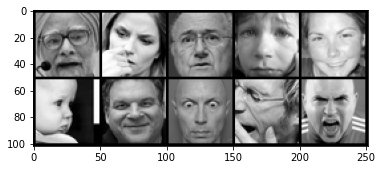

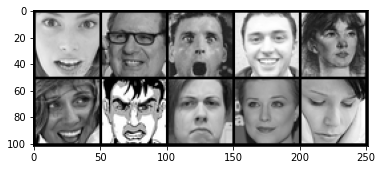

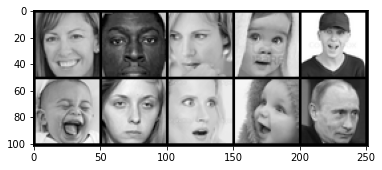

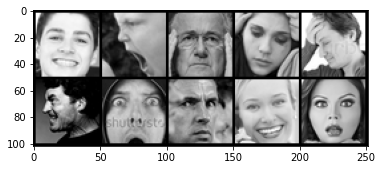

In [36]:
for i, batch in enumerate(training_folder_loader):
    grid = make_grid(batch[0], nrow=5)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    
    if i == 3:
        break

[1 2 5 6 8]


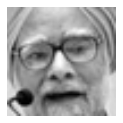

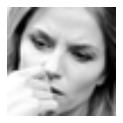

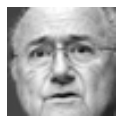

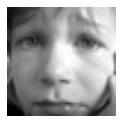

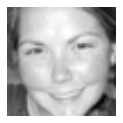

In [37]:
#double check for the first row of images
train_idx[:5]
print(train_idx[:5])
for idx in train_idx[:5]:
    plt.figure(figsize=(2, 2))
    plt.imshow(fer_dataset[idx][0].numpy().transpose(1, 2, 0), 
               interpolation="bilinear", cmap="gray")
    plt.axis("off")
    plt.show()


#### Caveat

There is a caveat with this approach: if you would pass in a `sampler` to a `DataLoader`, it won't be possible to use `shuffle=True` for batches in training.

However, that could be easily resolved by substituting the custom `FoldSampler` with the built-in `SubsetRandomSampler` and indices will be **permuted** every epoch automatically as it would happen with the `shuffle` parameter.

---